<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_40).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Participacion electoral)](#Analisis-por-grupo-de-indicadores-(esperanza-de-vida))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Participacion electoral)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Participacion']]

In [5]:
df_var = df_sel.dropna()

In [6]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8541 entries, 0 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   8541 non-null   int64  
 1   Trimestre             8541 non-null   int64  
 2   Mes                   8541 non-null   int64  
 3   Codi_Districte        8541 non-null   int64  
 4   Nom_Districte         8541 non-null   object 
 5   Codi_Barri            8541 non-null   int64  
 6   Nom_Barri             8541 non-null   object 
 7   Compraventa_Unitario  8541 non-null   float64
 8   Participacion         8541 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 600.7+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [9]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Participacion
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,41.8
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,41.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Participacion
Fecha,,
2014-01-01,1511.900000,57.6
2014-02-01,1511.900000,57.6
2014-03-01,1511.900000,57.6
2014-04-01,1633.069231,57.6
2014-05-01,1633.069231,57.6


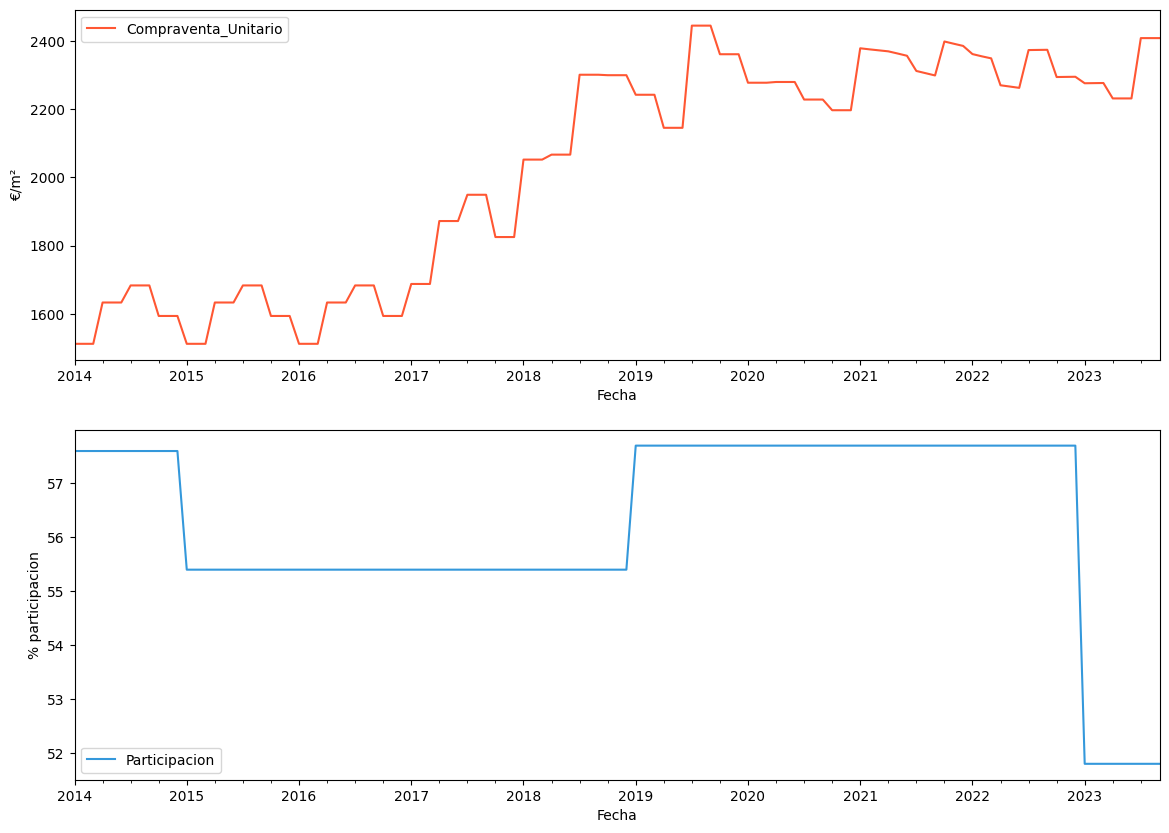

In [13]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% participacion']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [14]:
corr=df.corr()
corr

,Compraventa_Unitario,Participacion
Compraventa_Unitario,1.000000,0.162758
Participacion,0.162758,1.000000


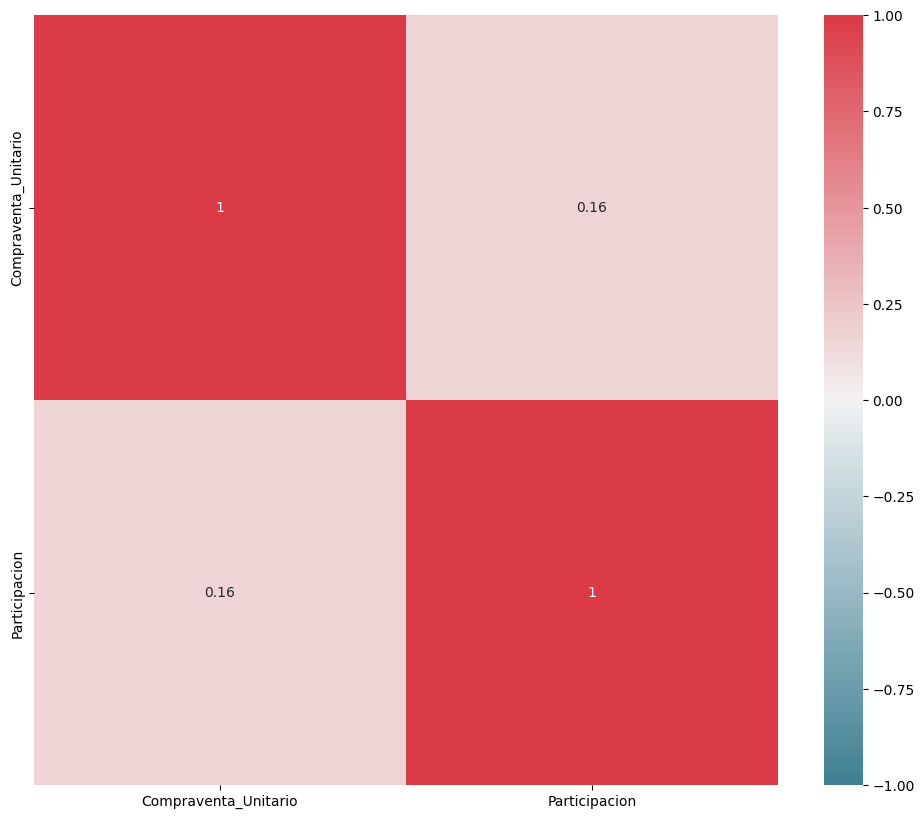

In [15]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar apenas existe correlacion entre las dos variables

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [16]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(108, 2) (9, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [17]:
import statsmodels.tsa.stattools as sts

In [18]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.586795
Serie de tiempo Participacion
p-value: 0.594248


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [19]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Participacion
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


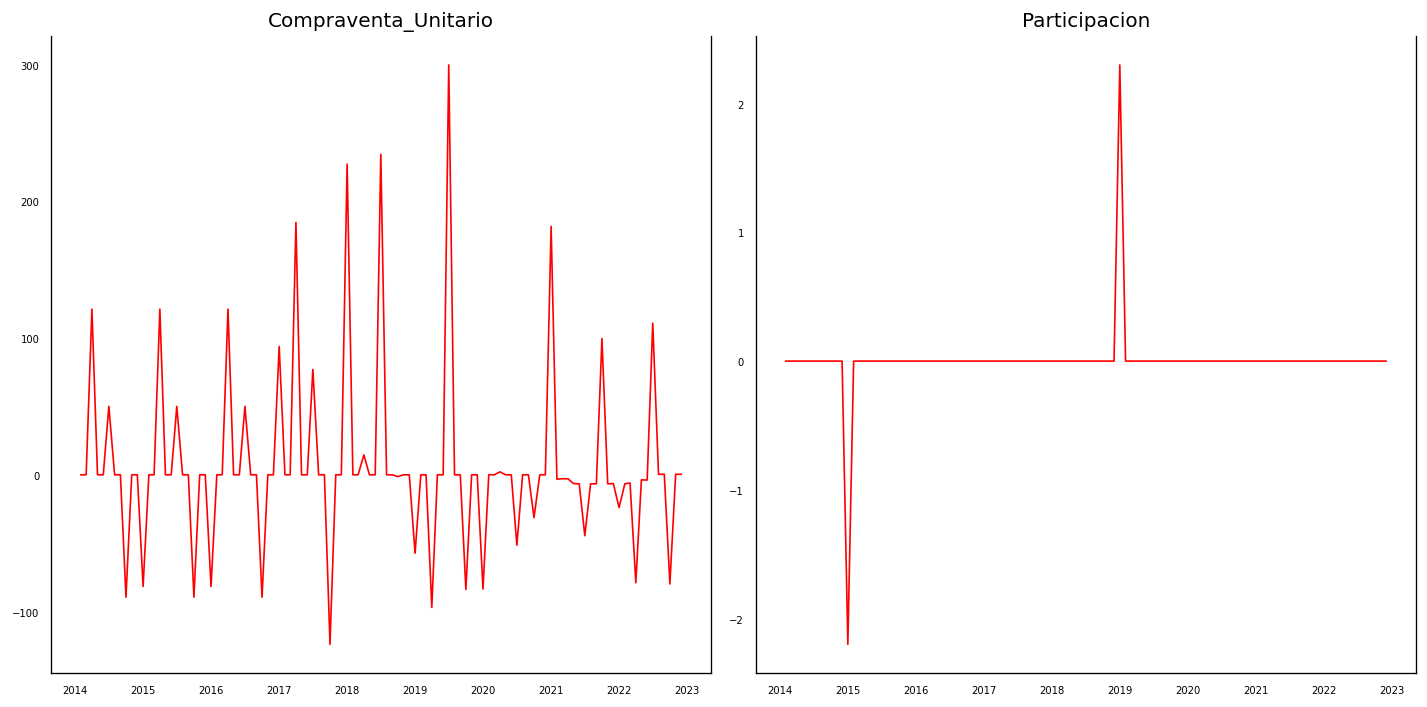

In [20]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [21]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Participacion
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [22]:
from statsmodels.tsa.api import VAR

In [23]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

El término "select order" se refiere al proceso de selección del orden óptimo del modelo, es decir, el número adecuado de lags para incluir en el modelo VAR.

In [24]:
# Establecemos un select order, de 30 periodos
modelsel=model.select_order(30)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,5.813,5.874*,334.6*,5.837*
1,5.916,6.099,370.9,5.989
2,6.019,6.323,411.2,6.141
3,6.013,6.439,409.0,6.183
4,6.112,6.660,452.1,6.331
5,6.210,6.880,499.7,6.478
6,5.908,6.699,370.2,6.224
7,6.010,6.923,411.5,6.375
8,6.111,7.146,457.7,6.525
9,6.139,7.295,473.2,6.601


#### Ajustando el modelo

In [25]:
res = model.fit(maxlags=30, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     05:14:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.47999
Nobs:                     77.0000    HQIC:                   7.25182
Log likelihood:          -318.524    FPE:                    999.174
AIC:                      5.76643    Det(Omega_mle):         311.075
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           15.064315        17.317659            0.870           0.384
L1.Compraventa_Unitario         -0.045835         0.305096           -0.150           0.881
L

El valor -0.775 indica una correlación negativa moderadamente fuerte entre los residuos de dos variables en el modelo. Esto sugiere que cuando el residuo de una variable es alto, el residuo de la otra variable tiende a ser bajo, y viceversa.

In [26]:
X_train.columns

Index(['Compraventa_Unitario', 'Participacion'], dtype='object')

###### Causalidad de Granger

In [27]:
grangercaus=res.test_causality(['Participacion'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.558,1.817,0.110,"(30, 32)"


In [28]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Participacion'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.1062,1.817,1.000,"(30, 32)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

###### Matriz de causalidad de Granger


In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Participacion_x
Compraventa_Unitario_y,1.0,0.0569
Participacion_y,0.0,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [30]:
residuals=res.resid

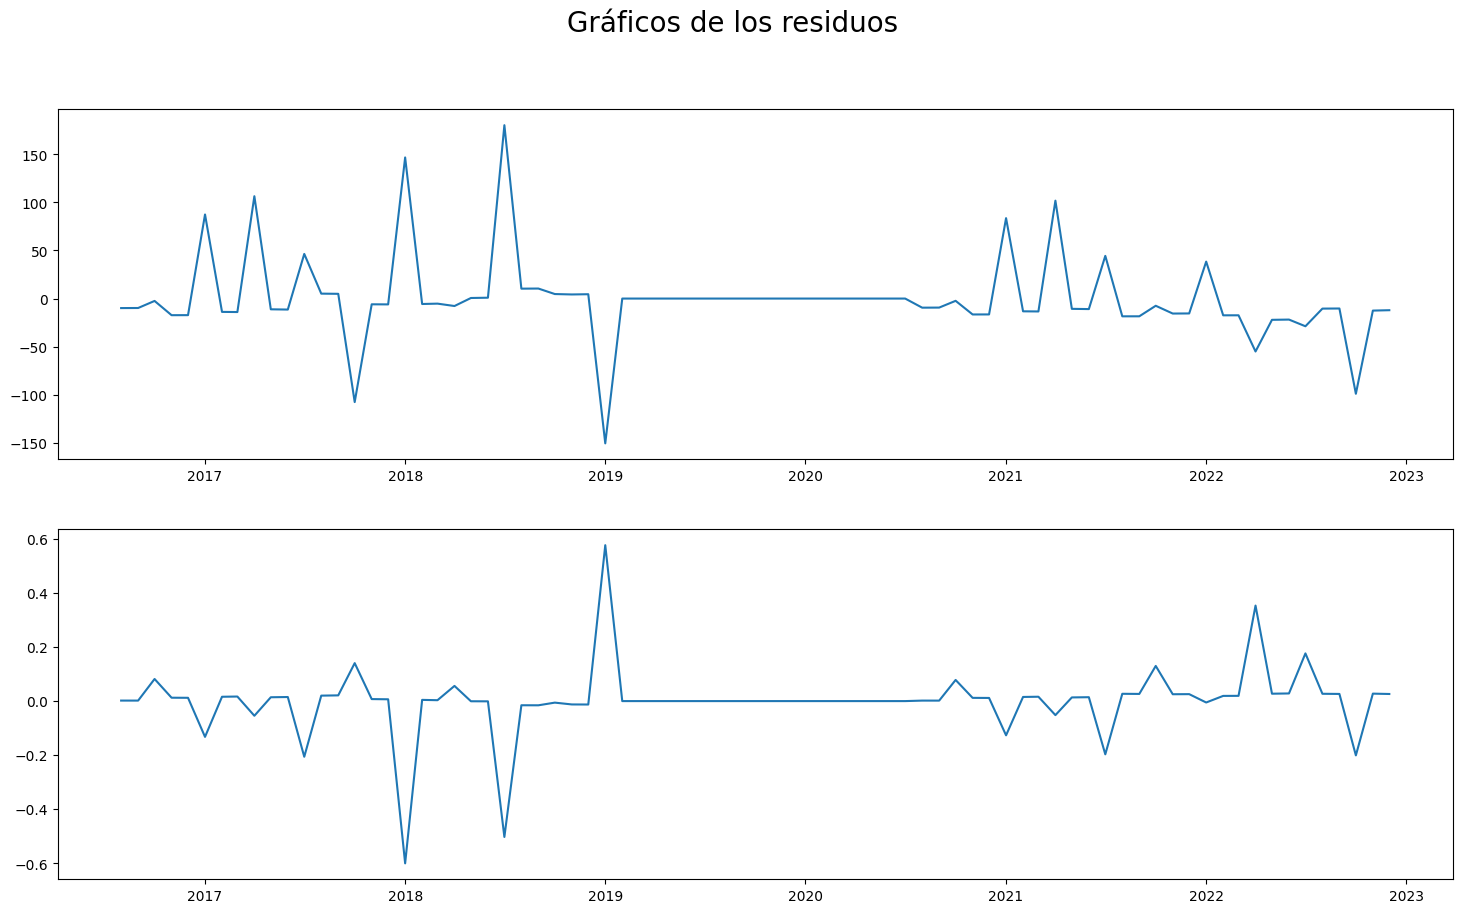

In [31]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [32]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[1.5221980892408385e-14, 7.741485955716517e-14]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


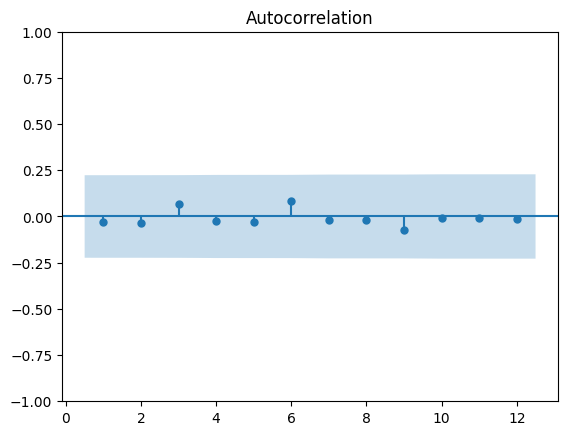

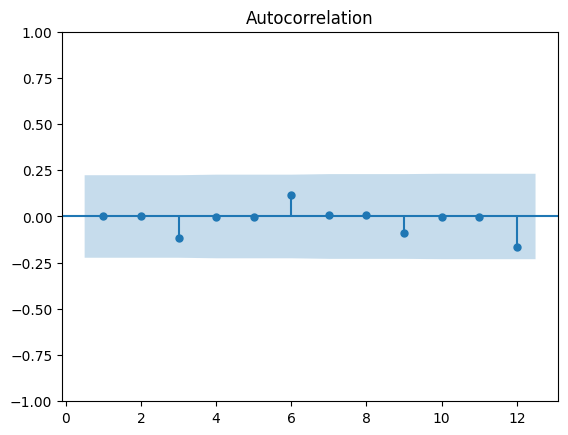

In [33]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


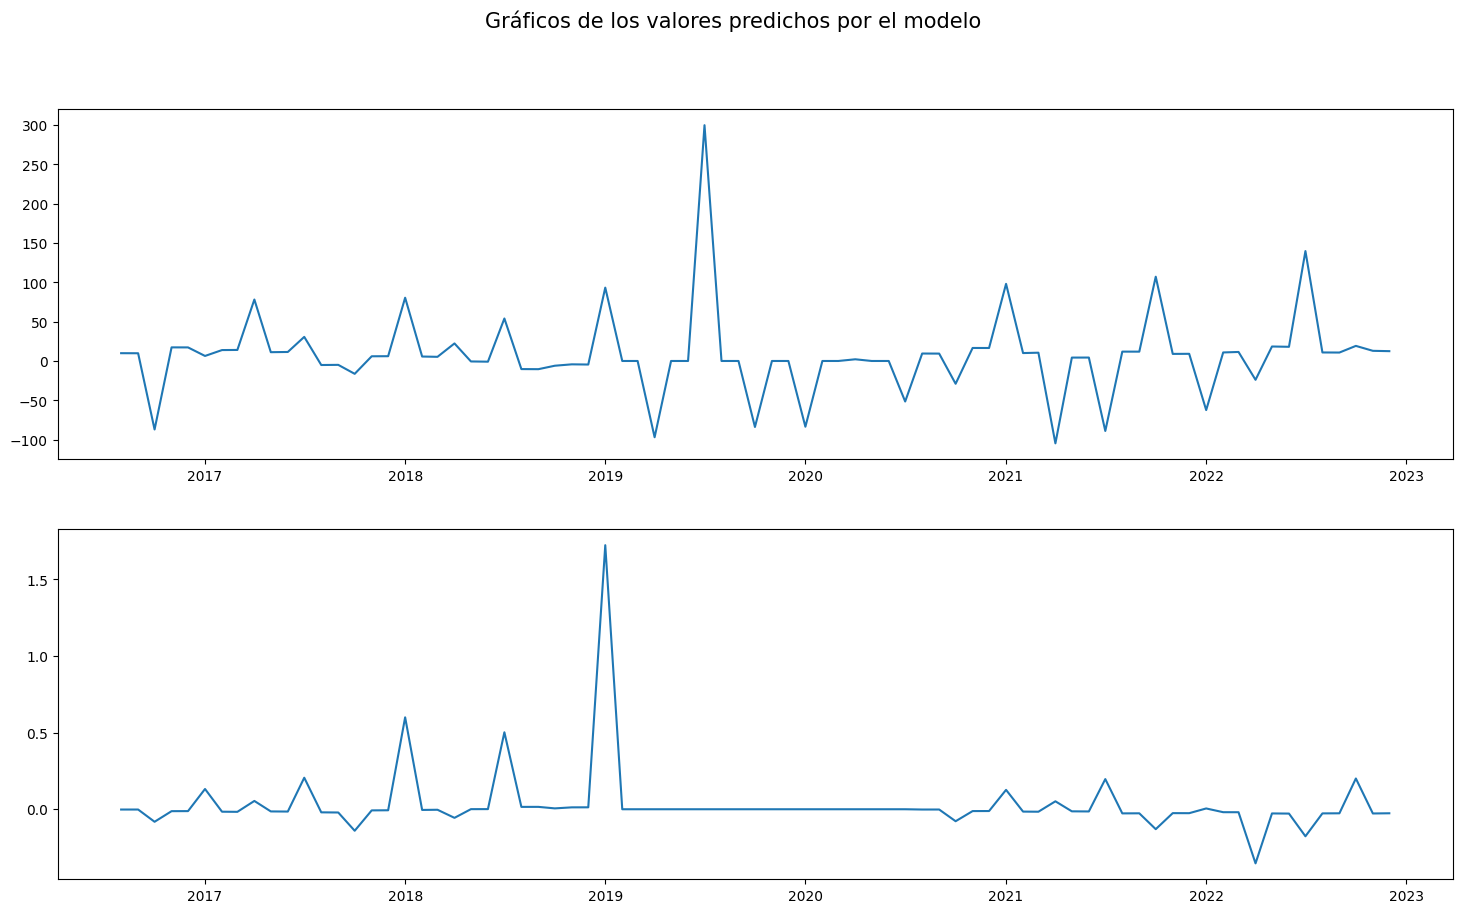

In [34]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [35]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 30
Predicciones:


,Compraventa_Unitario_pred,Participacion_pred
Fecha,,
2023-01-01,-10.513650,0.740805
2023-02-01,12.533535,-0.085796
2023-03-01,11.676580,-0.083685
2023-04-01,63.520488,-0.296131
2023-05-01,4.496867,-0.061490
2023-06-01,4.860928,-0.062187
2023-07-01,7.540355,0.211178
2023-08-01,11.865028,-0.011475
2023-09-01,11.412811,-0.011548


<Figure size 1200x1000 with 0 Axes>

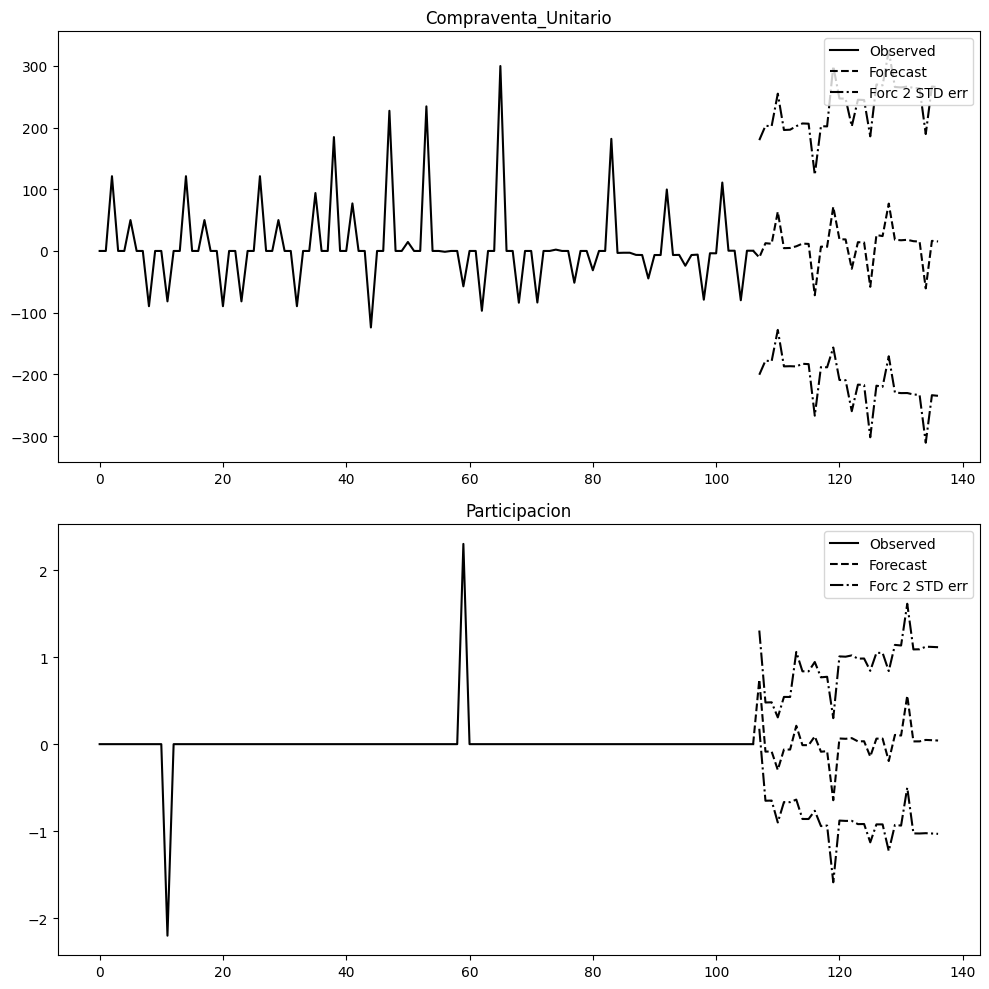

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [37]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [38]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Participacion
Fecha,,
2023-01-01,2284.709120,58.440805
2023-02-01,2297.242656,58.355009
2023-03-01,2308.919236,58.271323
2023-04-01,2372.439723,57.975192
2023-05-01,2376.936591,57.913702
2023-06-01,2381.797519,57.851516
2023-07-01,2389.337874,58.062694
2023-08-01,2401.202902,58.051219
2023-09-01,2412.615713,58.039670


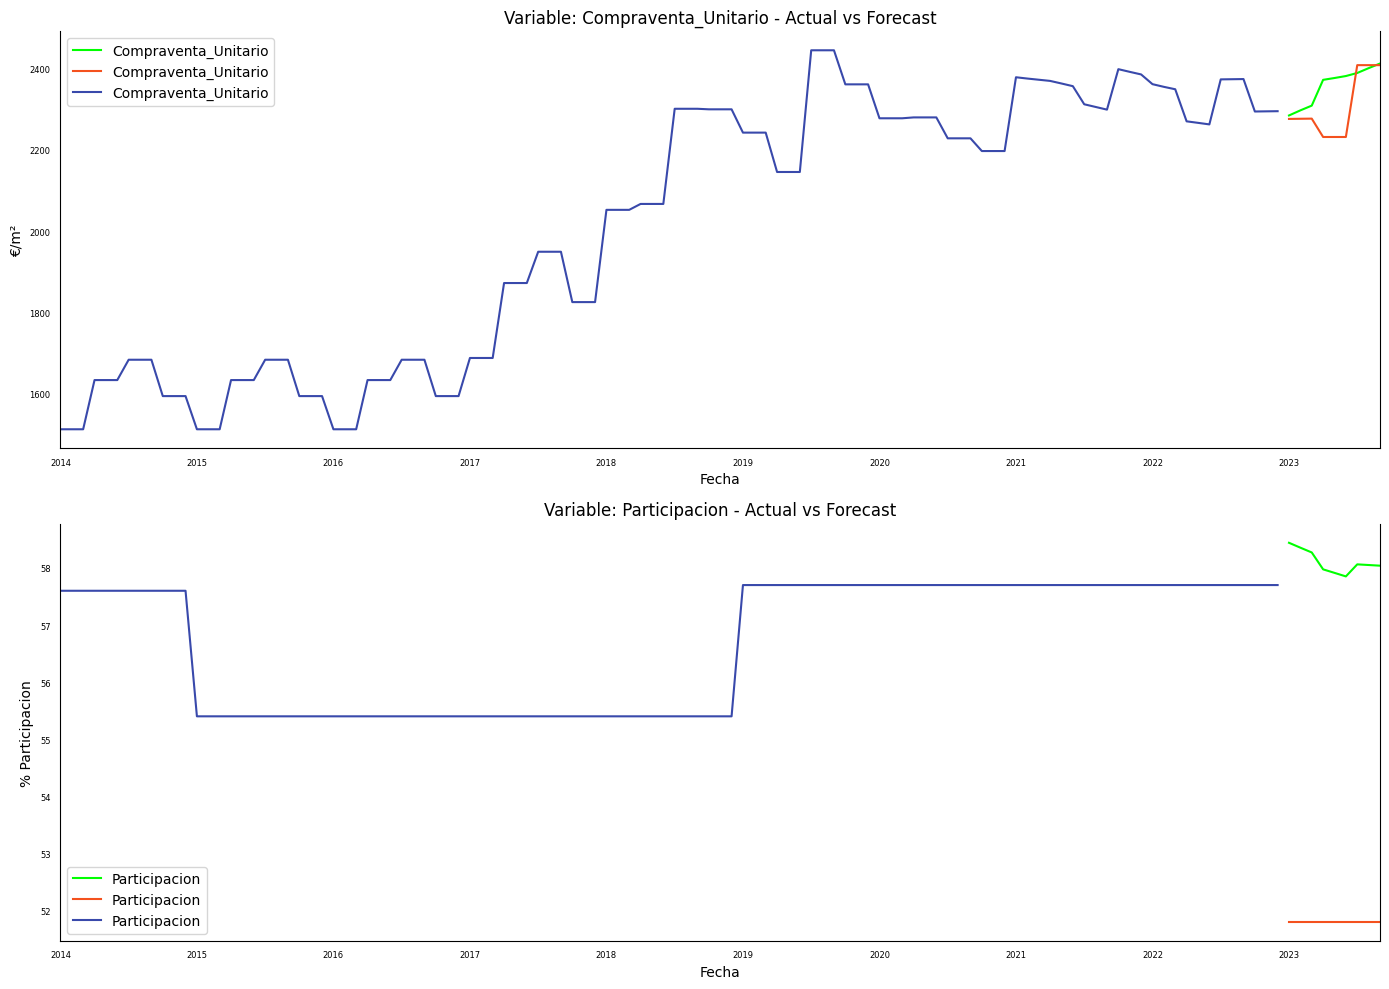

In [39]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Participacion']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [40]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [41]:
for i in ['Compraventa_Unitario','Participacion']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 7267.153009500161
MAE is : 58.666400658794274
RMSE is : 85.2475982623567
MAPE is : 2.6115346725889195
R2 is : -0.2885222342838103

Evaluation metric for Participacion
Evaluation metric results:-
MSE is : 39.81224422283552
MAE is : 6.306792151220362
RMSE is : 6.309694463508952
MAPE is : 12.175274423205334
R2 is : 0.0



Los resultados de este modelo entre estas dos series temporales no son buenos. Vemos como los valores predichos de la serie temporal de compraventa unitario se ajustan a la tendencia, pero los de la serie temporal de % de participacion electoral no.

En este modelo se dan todos los puntos criticos para considerar su eficacia:
- Un orden del modelo elevevado (30) que puede tener implicaciones de sobreajuste, complejidad en el modelo, dificultando la interpretacion y aumentando la probabilidad de error
- Correlacion de residuos que indica una fuerte correlacion negativa entre las dos series temporales
- Un test de causalidad de Granger que, como ya anticipaba la correlacion de residuos, nos indica que una serie temporal no causa la otra, es decir no tienen relaciones dinamicas, lo que limita la capacidad predictiva de este modelo e hace un modelado incorrecto de la relacion entre las dos series temporales.



In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 32.48659640500732
Root mean squared error: 60.44404542104622


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [43]:
!pip install pmdarima

#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [44]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(108, 2) (9, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [45]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.586795
Serie de tiempo Participacion
p-value: 0.594248


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [46]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Participacion
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


In [47]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Participacion
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [48]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [49]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'Participacion']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  48.23     > 12.3212   =>   True
Participacion >  12.68     > 4.1296    =>   True


Los resultados del test de Cointegracion entre las dos series temporales son satisfactorios.

- Para "Compraventa_Unitario", el valor del estadístico de prueba es 48.23, lo cual es mucho mayor que el valor crítico de 12.3212 al 95% de confianza. Esto indica que hay evidencia significativa de cointegración para esta variable.

- Para "Participacion", el valor del estadístico de prueba es 12.68, nuevamente mucho mayor que el valor crítico de 4.1296 al 95% de confianza. Esto también indica que hay evidencia significativa de cointegración para esta variable.

A pesar de las fluctuaciones a corto plazo, ambas variables tienden a moverse juntas en el largo plazo. Esto es importante para la modelización y el análisis de series temporales, ya que proporciona información sobre la relación a largo plazo entre las variables y puede ayudar en la construcción de modelos más precisos y en la formulación de políticas adecuadas.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [50]:
import pmdarima as pm

In [51]:

pq = []
for name in ['Compraventa_Unitario', 'Participacion']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1198.697, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1200.697, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1200.697, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1202.699, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1199.327, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.488 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Participacion
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.419, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=55.419, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55.419, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=57.419, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55.418, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0

#####Seleccion del modelo

In [52]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [53]:
pq

[(0, 0, 0), (0, 0, 0)]

Los valores obtenidos para p y q en las dos series son 0, lo que:
- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

El Modelo VARMAX se simplifica a un modelo VAR, considerandose unicamente las relaciones lineales entre las variables en si mismas y no hay componentes de error que se autoregresen

In [54]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [55]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE Participacion'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'Participacion']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 9)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'Participacion']] , result, True)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Paradosrmse = np.sqrt(metrics.mean_squared_error(X_test['Participacion'], inv_res.Participacion))
        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Paradosrmse]


Grid Search Started


In [56]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE Participacion'] )

,p,q,RMSE Compraventa_Unitario,RMSE Participacion


#### Pronósticos a futuro


In [57]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','Participacion']], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 9)

In [58]:
result

,Compraventa_Unitario,Participacion
2023-01-01,7.609766,0.000884
2023-02-01,7.438471,0.000878
2023-03-01,7.320775,0.000910
2023-04-01,7.320775,0.000910
2023-05-01,7.320775,0.000910
2023-06-01,7.320775,0.000910
2023-07-01,7.320775,0.000910
2023-08-01,7.320775,0.000910
2023-09-01,7.320775,0.000910


#### Invertiendo la transformacion de los pronosticos a la escala original

In [59]:
res = inverse_diff(df[['Compraventa_Unitario', 'Participacion']],result,True)

In [60]:
res

,Compraventa_Unitario,Participacion
2023-01-01,2416.232842,51.800884
2023-02-01,2431.281079,51.802646
2023-03-01,2453.650091,51.805318
2023-04-01,2483.339876,51.808899
2023-05-01,2520.350437,51.813391
2023-06-01,2564.681772,51.818793
2023-07-01,2616.333881,51.825104
2023-08-01,2675.306765,51.832325
2023-09-01,2741.600423,51.840456


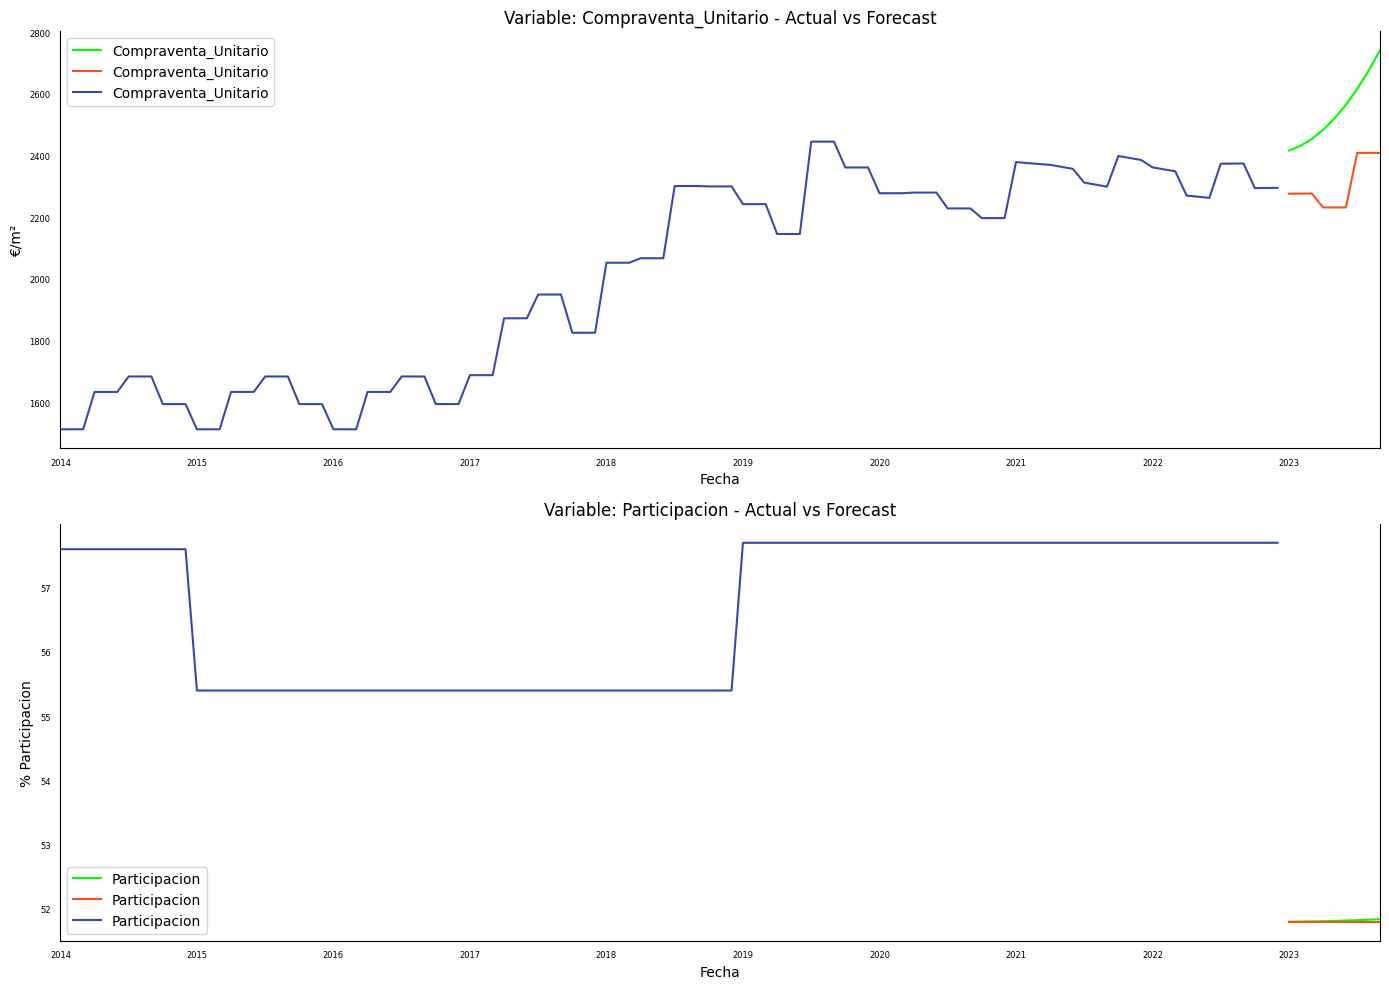

In [61]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Participacion']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [62]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [63]:
for i in ['Compraventa_Unitario','Participacion']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 61939.36373719842
MAE is : 239.12918699455187
RMSE is : 248.8762016288388
MAPE is : 10.373581950093364
R2 is : -9.982326538114537

Evaluation metric for Participacion
Evaluation metric results:-
MSE is : 0.0004399543817615488
MAE is : 0.01642403614028609
RMSE is : 0.02097508955312346
MAPE is : 0.03170663347545578
R2 is : 0.0



Los resultados de este modelo entre estas dos series temporales no son bueno, aunque los valores predichos de la series temporales capturan la tendencia de los datos.
  - Tal y como hemos comentado anteriormente, el metodo de Autoarima nos ha calculado para p y q valores de 0, lo que indica que el modelo VARMAX se simplifica a un modelo VAR estandar.
  - El test de cointegracion entre las dos series temporales nos arroja buenos resultados, indicando que apesar de las fluctuaciones a corto plazo, las dos series tienden a moverse juntas a largo plazo.


In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 119.57280551534608
Root mean squared error: 175.98205047270133


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y Participacion, tenemos que:

- Se ha comprobado que las variables apenas tienen correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del primer orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que serie estos datos pueden ser aptos para este modelo

Como hemos visto, los modelos obtenidos no se ajustan a los datos de test, dado que las series temporales no cumplen varias limitaciones de los modelos a aplicar. Fruto de ellos son modelos con limitaciones en la capacidad predictiva, y modelado incorrecto de la relacion entre ellas.  

